# Dimension Analysis Experiment

This notebook investigates the retained dimension and eigenvalue decay for the Markov operators at each time slice.
It also includes local linear regression residual analysis to identify non-harmonic intrinsic coordinates.

## Workflow

The analysis is broken into examinable steps:

1. **Bandwidth Selection**: Select optimal epsilon for each time slice using semigroup error
2. **Visualization**: Examine the semigroup error curves
3. **Diffusion Maps**: Compute eigenvectors/eigenvalues with extensive diagnostics
4. **Error Recovery**: Automatically detect and fix numerical issues (e.g., sparse kernels)
5. **LLR Residuals**: Identify unique (non-harmonic) eigenvector directions
6. **Results Compilation**: Combine all results for analysis
7. **Diagnostics**: Review kernel statistics and identify problematic cases
8. **Visualization**: Create comprehensive plots of eigenvalue decay and LLR residuals

This modular approach allows you to:
- Inspect intermediate results at each step
- Debug numerical issues more easily  
- Understand which time slices are problematic and why
- Re-run specific steps without recomputing everything

In [1]:
import sys
import os
import json
import pickle
from pathlib import Path
from typing import Optional, Dict, List, Any, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# --- Caching Infrastructure ---
CACHE_DIR = Path("../data/cache_dimension_analysis")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = CACHE_DIR / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FORCE_RECOMPUTE = False

def load_or_compute(
    cache_name: str,
    compute_fn: Callable[[], Any],
    force: bool = False
) -> Any:
    """Load result from cache if available, otherwise compute and save."""
    cache_path = CACHE_DIR / f"{cache_name}.pkl"
    if not force and not FORCE_RECOMPUTE and cache_path.exists():
        print(f"Loading {cache_name} from cache: {cache_path}")
        try:
            with open(cache_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Failed to load cache {cache_name}: {e}. Recomputing...")
    
    print(f"Computing {cache_name}...")
    result = compute_fn()
    
    print(f"Saving {cache_name} to cache: {cache_path}")
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)
    return result

# Make repository root importable when executing from the notebooks directory
try:
    sys.path.append(str(Path(__file__).resolve().parent.parent))
except NameError:
    import os
    sys.path.append(os.path.abspath(".."))

from diffmap.diffusion_maps import (
    select_optimal_bandwidth,
    select_non_harmonic_coordinates,
    _time_slice_markov,
)
from tran_inclusions.data_prep import load_tran_inclusions_data, compute_bandwidth_statistics
from sklearn.utils.extmath import randomized_svd

In [2]:
def format_for_paper() -> None:
    """Apply publication-style defaults for matplotlib figures."""
    plt.rcParams.update({"image.cmap": "viridis"})
    plt.rcParams.update(
        {
            "font.serif": [
                "Times New Roman",
                "Times",
                "DejaVu Serif",
                "Bitstream Vera Serif",
                "Computer Modern Roman",
                "New Century Schoolbook",
                "Century Schoolbook L",
                "Utopia",
                "ITC Bookman",
                "Bookman",
                "Nimbus Roman No9 L",
                "Palatino",
                "Charter",
                "serif",
            ]
        }
    )
    plt.rcParams.update({"font.family": "serif"})
    plt.rcParams.update({"font.size": 10})
    plt.rcParams.update({"mathtext.fontset": "custom"})
    plt.rcParams.update({"mathtext.rm": "serif"})
    plt.rcParams.update({"mathtext.it": "serif:italic"})
    plt.rcParams.update({"mathtext.bf": "serif:bold"})
    plt.close("all")

format_for_paper()

In [3]:
# Parameters
data_path = Path("../data/tran_inclusions.npz")
epsilon_selection_mode = 'first_local_minimum'
max_eigenvectors = 128  # Number of eigenvectors to compute and analyze
LLR_RESIDUAL_THRESHOLD = 0.1

In [4]:
(
    times_arr,
    held_out_indices,
    held_out_times,
    all_frames,
    components,
    mean_vec,
    explained_variance,
    is_whitened,
    whitening_epsilon,
    resolution,
    raw_marginals,
    held_out_marginals,
) = load_tran_inclusions_data(data_path)

print(f"Loaded data: {all_frames.shape} (Time, Samples, PCA_Comps)")
print(f"Time points: {times_arr}")

# %% [markdown]
# ## Dimension Analysis Loop

Loaded data: (7, 5000, 376) (Time, Samples, PCA_Comps)
Time points: [0.11111111 0.22222222 0.44444444 0.55555556 0.66666667 0.88888889
 1.        ]


In [5]:
## Step 1: Bandwidth Selection for All Time Slices

First, we'll select optimal bandwidths for each time slice using the semigroup error criterion.

SyntaxError: unterminated string literal (detected at line 3) (3629172651.py, line 3)

In [6]:
# Compute bandwidth statistics for all frames
bandwidth_stats = compute_bandwidth_statistics(all_frames)
base_epsilons = bandwidth_stats['median']  # Array of medians per frame

# Select optimal bandwidth for each time slice
n_times = all_frames.shape[0]
epsilon_results = []

for idx in range(n_times):
    print(f"Time slice {idx}/{n_times} (t={times_arr[idx]:.3f}): Selecting bandwidth...")
    coords = all_frames[idx]
    
    base_eps = base_epsilons[idx]
    scales = np.geomspace(0.01, 0.2, num=32)
    candidates = base_eps * scales
    
    print(f"  Base ε (median dist²): {base_eps:.4e}, candidates: [{candidates.min():.4e}, {candidates.max():.4e}]")
    
    eps_k, score_k, all_eps, all_scores = select_optimal_bandwidth(
        coords,
        candidate_epsilons=candidates,
        alpha=1.0,
        epsilon_scaling=4.0,
        selection=epsilon_selection_mode,
        return_all=True,
    )
    
    print(f"  Selected ε = {eps_k:.4e}, SGE = {score_k:.4e}")
    
    epsilon_results.append({
        'time': times_arr[idx],
        'epsilon': eps_k,
        'semigroup_error': score_k,
        'all_epsilons': all_eps,
        'all_scores': all_scores,
        'base_epsilon': base_eps,
    })

print(f"\nCompleted bandwidth selection for {n_times} time slices.")

Time slice 0/7 (t=0.111): Selecting bandwidth...
  Base ε (median dist²): 2.3211e+03, candidates: [2.3211e+01, 4.6422e+02]
  Selected ε = 4.5654e+01, SGE = 6.2537e-02
Time slice 1/7 (t=0.222): Selecting bandwidth...
  Base ε (median dist²): 1.9287e+03, candidates: [1.9287e+01, 3.8573e+02]
  Selected ε = 3.7935e+01, SGE = 6.4658e-02
Time slice 2/7 (t=0.444): Selecting bandwidth...
  Base ε (median dist²): 1.6048e+03, candidates: [1.6048e+01, 3.2095e+02]
  Selected ε = 2.8656e+01, SGE = 6.5550e-02
Time slice 3/7 (t=0.556): Selecting bandwidth...
  Base ε (median dist²): 1.4646e+03, candidates: [1.4646e+01, 2.9293e+02]
  Selected ε = 2.6154e+01, SGE = 6.5789e-02
Time slice 4/7 (t=0.667): Selecting bandwidth...
  Base ε (median dist²): 9.3282e+02, candidates: [9.3282e+00, 1.8656e+02]
  Selected ε = 2.0209e+01, SGE = 6.6913e-02
Time slice 5/7 (t=0.889): Selecting bandwidth...
  Base ε (median dist²): 4.1896e+02, candidates: [4.1896e+00, 8.3792e+01]
  Selected ε = 1.4715e+01, SGE = 6.7097e-0

## Step 2: Visualize Bandwidth Selection

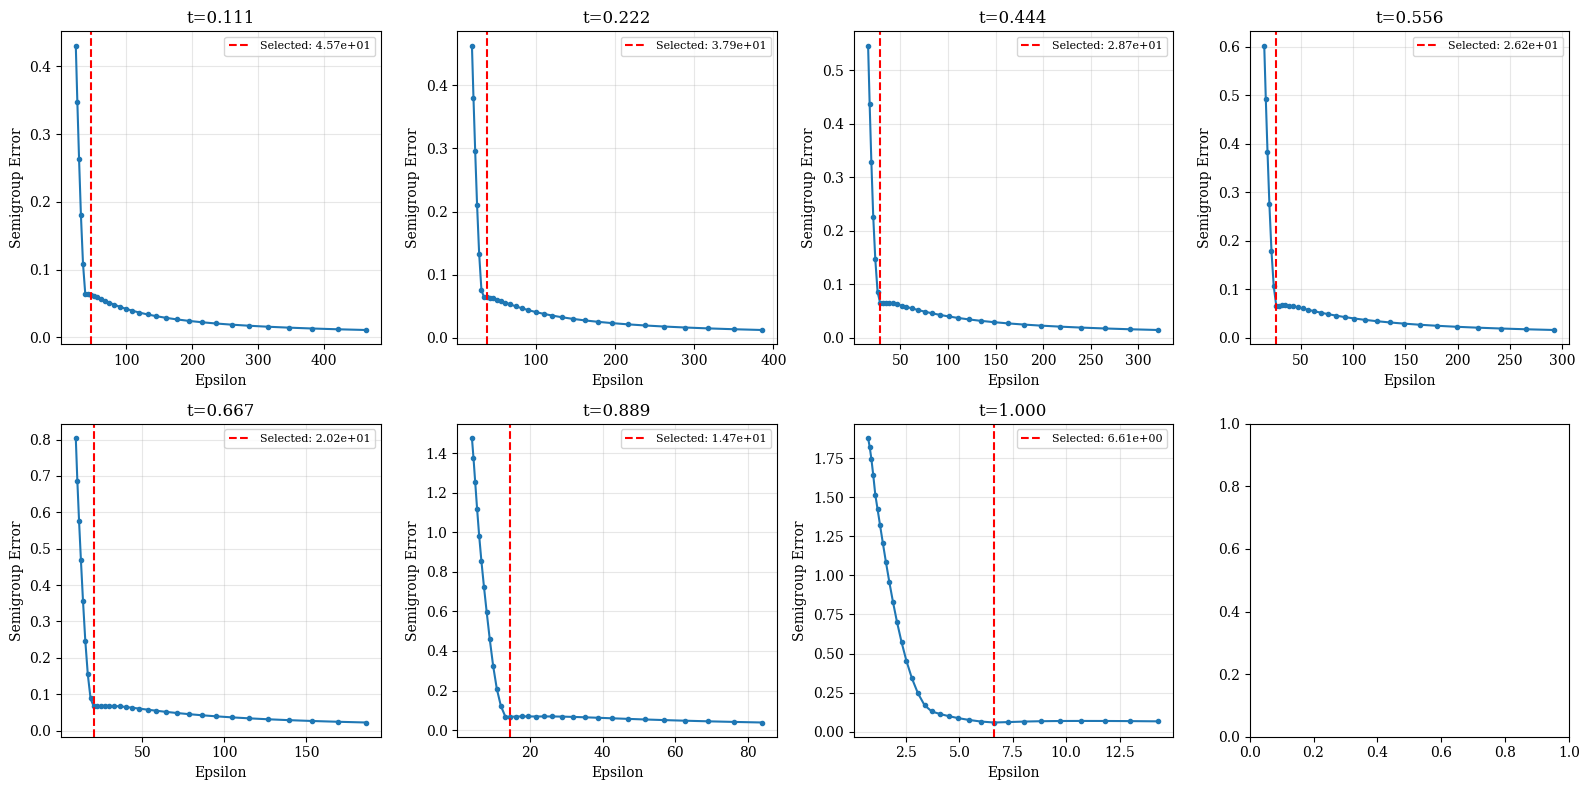


=== Bandwidth Selection Summary ===
Selected ε range: [6.6098e+00, 4.5654e+01]
Mean ε: 2.5705e+01 ± 1.2375e+01


In [7]:
# Visualize semigroup error curves and selected bandwidths
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, res in enumerate(epsilon_results):
    if idx >= len(axes):
        break
    ax = axes[idx]
    ax.plot(res['all_epsilons'], res['all_scores'], 'o-', markersize=3)
    ax.axvline(res['epsilon'], color='r', linestyle='--', label=f"Selected: {res['epsilon']:.2e}")
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Semigroup Error')
    ax.set_title(f"t={res['time']:.3f}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "semigroup_error_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary statistics
epsilons = np.array([r['epsilon'] for r in epsilon_results])
times = np.array([r['time'] for r in epsilon_results])
print("\n=== Bandwidth Selection Summary ===")
print(f"Selected ε range: [{epsilons.min():.4e}, {epsilons.max():.4e}]")
print(f"Mean ε: {epsilons.mean():.4e} ± {epsilons.std():.4e}")

## Step 3: Compute Diffusion Maps for Each Time Slice

Now we'll compute the diffusion map eigenvectors and eigenvalues, with diagnostics to detect numerical issues.

In [8]:
def compute_diffusion_map_with_diagnostics(coords, epsilon, alpha=1.0, max_eigs=128):
    """
    Compute diffusion map with extensive diagnostics to catch numerical issues.
    
    Returns:
        dict with keys: eigvals, eigvecs, diff_coords, P_sym, diagnostics, success
    """
    diagnostics = {}
    
    # Compute pairwise distances
    distances2 = squareform(pdist(coords, metric="sqeuclidean"))
    diagnostics['dist_min'] = distances2[distances2 > 0].min() if np.any(distances2 > 0) else 0
    diagnostics['dist_max'] = distances2.max()
    diagnostics['dist_median'] = np.median(distances2[distances2 > 0]) if np.any(distances2 > 0) else 0
    
    # Build kernel with diagnostics
    kernel = np.exp(-distances2 / (4.0 * epsilon))
    np.fill_diagonal(kernel, 0.0)
    
    degrees = kernel.sum(axis=1)
    diagnostics['degree_min'] = degrees.min()
    diagnostics['degree_max'] = degrees.max()
    diagnostics['degree_mean'] = degrees.mean()
    
    # Check for degeneracy
    if degrees.min() < 1e-10:
        diagnostics['warning'] = f"Near-zero degrees detected: min={degrees.min():.4e}"
        return {'success': False, 'diagnostics': diagnostics, 'reason': 'degenerate_kernel'}
    
    # Alpha normalization with safe power computation
    # Clip degrees to avoid overflow in power
    degrees_safe = np.clip(degrees, 1e-12, None)
    inv_deg = np.power(degrees_safe, -alpha)
    
    # Check for overflow
    if not np.all(np.isfinite(inv_deg)):
        diagnostics['warning'] = "Overflow in alpha normalization"
        return {'success': False, 'diagnostics': diagnostics, 'reason': 'alpha_overflow'}
    
    kernel_alpha = (inv_deg[:, None] * kernel) * inv_deg[None, :]
    
    # Symmetric normalization
    d_alpha = kernel_alpha.sum(axis=1)
    d_alpha_safe = np.clip(d_alpha, 1e-12, None)
    inv_sqrt_d = np.power(d_alpha_safe, -0.5)
    
    if not np.all(np.isfinite(inv_sqrt_d)):
        diagnostics['warning'] = "Overflow in symmetric normalization"
        return {'success': False, 'diagnostics': diagnostics, 'reason': 'sym_overflow'}
    
    P_sym = (inv_sqrt_d[:, None] * kernel_alpha) * inv_sqrt_d[None, :]
    
    # Check for NaN/Inf
    if not np.all(np.isfinite(P_sym)):
        diagnostics['warning'] = "P_sym contains NaN/Inf"
        return {'success': False, 'diagnostics': diagnostics, 'reason': 'psym_invalid'}
    
    # Eigendecomposition
    n_eigs = min(max_eigs, P_sym.shape[0] - 1)
    try:
        U, S, Vt = randomized_svd(P_sym, n_components=n_eigs, random_state=42)
        eigvals = S
        eigvecs = U
        
        # Convert to diffusion coordinates
        psi = inv_sqrt_d[:, None] * eigvecs
        diff_coords = psi * eigvals[None, :]
        
        diagnostics['n_eigenvectors'] = len(eigvals)
        diagnostics['eigenvalue_min'] = eigvals.min()
        diagnostics['eigenvalue_max'] = eigvals.max()
        
        return {
            'success': True,
            'eigvals': eigvals,
            'eigvecs': eigvecs,
            'diff_coords': diff_coords,
            'P_sym': P_sym,
            'diagnostics': diagnostics
        }
    except Exception as e:
        diagnostics['warning'] = f"SVD failed: {str(e)}"
        return {'success': False, 'diagnostics': diagnostics, 'reason': 'svd_failed'}


# Compute diffusion maps for all time slices
diffusion_results = []

for idx in range(n_times):
    print(f"\n=== Time slice {idx}/{n_times} (t={times_arr[idx]:.3f}) ===")
    coords = all_frames[idx]
    eps_k = epsilon_results[idx]['epsilon']
    
    result = compute_diffusion_map_with_diagnostics(
        coords, 
        eps_k, 
        alpha=1.0, 
        max_eigs=max_eigenvectors
    )
    
    # Print diagnostics
    diag = result['diagnostics']
    print(f"  Epsilon: {eps_k:.4e}")
    print(f"  Distance stats: min={diag.get('dist_min', np.nan):.4e}, "
          f"median={diag.get('dist_median', np.nan):.4e}, max={diag.get('dist_max', np.nan):.4e}")
    print(f"  Kernel degrees: min={diag.get('degree_min', np.nan):.4e}, "
          f"mean={diag.get('degree_mean', np.nan):.4e}, max={diag.get('degree_max', np.nan):.4e}")
    
    if result['success']:
        print(f"  ✓ Success: {diag['n_eigenvectors']} eigenvectors computed")
        print(f"  Eigenvalue range: [{diag['eigenvalue_min']:.4e}, {diag['eigenvalue_max']:.4e}]")
    else:
        print(f"  ✗ Failed: {result['reason']}")
        if 'warning' in diag:
            print(f"  Warning: {diag['warning']}")
    
    result['time'] = times_arr[idx]
    result['epsilon'] = eps_k
    diffusion_results.append(result)

# Summary
n_success = sum(r['success'] for r in diffusion_results)
print(f"\n{'='*60}")
print(f"Diffusion map computation: {n_success}/{n_times} successful")


=== Time slice 0/7 (t=0.111) ===
  Epsilon: 4.5654e+01
  Distance stats: min=1.0434e+03, median=2.3211e+03, max=3.5162e+03
  Kernel degrees: min=1.7141e-02, mean=4.0244e-02, max=8.5563e-02
  ✓ Success: 128 eigenvectors computed
  Eigenvalue range: [6.9295e-02, 1.0000e+00]

=== Time slice 1/7 (t=0.222) ===
  Epsilon: 3.7935e+01
  Distance stats: min=8.0220e+02, median=1.9287e+03, max=3.0511e+03
  Kernel degrees: min=1.5849e-02, mean=4.6629e-02, max=1.1023e-01
  ✓ Success: 128 eigenvectors computed
  Eigenvalue range: [8.2752e-02, 1.0000e+00]

=== Time slice 2/7 (t=0.444) ===
  Epsilon: 2.8656e+01
  Distance stats: min=5.9376e+02, median=1.6048e+03, max=2.6669e+03
  Kernel degrees: min=4.7312e-03, mean=1.9615e-02, max=5.4020e-02
  ✓ Success: 128 eigenvectors computed
  Eigenvalue range: [1.2424e-01, 1.0000e+00]

=== Time slice 3/7 (t=0.556) ===
  Epsilon: 2.6154e+01
  Distance stats: min=5.1001e+02, median=1.4646e+03, max=2.5022e+03
  Kernel degrees: min=4.5740e-03, mean=2.1621e-02, max

## Step 4: Analyze Failed Cases (if any)

If any diffusion map computations failed, let's examine why and potentially adjust the bandwidth.

In [9]:
# Identify failed cases
failed_indices = [i for i, r in enumerate(diffusion_results) if not r['success']]

if failed_indices:
    print(f"Found {len(failed_indices)} failed cases: {failed_indices}")
    print("\nAttempting to fix by using larger epsilon (more connectivity)...")
    
    for idx in failed_indices:
        print(f"\n--- Fixing time slice {idx} (t={times_arr[idx]:.3f}) ---")
        coords = all_frames[idx]
        eps_res = epsilon_results[idx]
        
        # Try progressively larger epsilons from the semigroup curve
        all_eps = eps_res['all_epsilons']
        all_scores = eps_res['all_scores']
        
        # Sort by increasing epsilon (more connectivity)
        sorted_idx = np.argsort(all_eps)
        
        for trial_idx in sorted_idx[::-1]:  # Start from largest epsilon
            trial_eps = all_eps[trial_idx]
            print(f"  Trying ε = {trial_eps:.4e}...")
            
            result = compute_diffusion_map_with_diagnostics(
                coords, 
                trial_eps, 
                alpha=1.0, 
                max_eigs=max_eigenvectors
            )
            
            if result['success']:
                print(f"  ✓ Success with ε = {trial_eps:.4e}")
                result['time'] = times_arr[idx]
                result['epsilon'] = trial_eps
                result['adjusted'] = True
                diffusion_results[idx] = result
                epsilon_results[idx]['epsilon'] = trial_eps  # Update for consistency
                break
        else:
            print(f"  ✗ Could not fix time slice {idx}")
    
    # Re-count successes
    n_success = sum(r['success'] for r in diffusion_results)
    print(f"\n{'='*60}")
    print(f"After adjustment: {n_success}/{n_times} successful")
else:
    print("All diffusion map computations succeeded!")

All diffusion map computations succeeded!


## Step 5: Compute LLR Residuals

Now compute the local linear regression residuals to identify non-harmonic eigenvector directions.

In [10]:
llr_results = []

for idx, diff_res in enumerate(diffusion_results):
    print(f"Time slice {idx} (t={times_arr[idx]:.3f}): ", end="")
    
    if not diff_res['success']:
        print("Skipped (diffusion map failed)")
        llr_results.append({
            'success': False,
            'residuals': np.full(max_eigenvectors, np.nan),
            'mask': np.zeros(max_eigenvectors, dtype=bool)
        })
        continue
    
    # Subsample for speed
    diff_coords = diff_res['diff_coords']
    n_sub = min(512, diff_coords.shape[0])
    rng = np.random.default_rng(42)
    sub_idx = rng.choice(diff_coords.shape[0], size=n_sub, replace=False)
    diff_coords_sub = diff_coords[sub_idx]
    
    eigvals = diff_res['eigvals']
    
    # Compute LLR residuals
    # Note: Two kernel scales (per Dsilva et al. 2018):
    # - epsilon (diffusion map kernel): already used
    # - LLR kernel scale: selected independently for eigenspace
    try:
        intrinsic, mask, residuals = select_non_harmonic_coordinates(
            eigvals,
            diff_coords_sub,
            residual_threshold=LLR_RESIDUAL_THRESHOLD,
            min_coordinates=2,
            # Option: use same scale as diffusion map
            # llr_kernel_scale=4.0 * diff_res['epsilon'],
        )
        print(f"✓ {mask.sum()} unique coordinates identified")
        llr_results.append({
            'success': True,
            'residuals': residuals,
            'mask': mask,
            'intrinsic': intrinsic
        })
    except Exception as e:
        print(f"✗ LLR failed: {str(e)[:50]}")
        llr_results.append({
            'success': False,
            'residuals': np.full(len(eigvals), np.nan),
            'mask': np.zeros(len(eigvals), dtype=bool)
        })

print(f"\nLLR computation: {sum(r['success'] for r in llr_results)}/{n_times} successful")

Time slice 0 (t=0.111): ✓ 109 unique coordinates identified
Time slice 1 (t=0.222): ✓ 98 unique coordinates identified
Time slice 2 (t=0.444): ✓ 2 unique coordinates identified
Time slice 3 (t=0.556): ✓ 20 unique coordinates identified
Time slice 4 (t=0.667): ✓ 46 unique coordinates identified
Time slice 5 (t=0.889): ✓ 9 unique coordinates identified
Time slice 6 (t=1.000): ✓ 29 unique coordinates identified

LLR computation: 7/7 successful


## Step 6: Compile Results for Visualization

Combine all results into a format suitable for saving and plotting.

In [11]:
# Compile final analysis results
analysis_results = []

for idx in range(n_times):
    if diffusion_results[idx]['success']:
        analysis_results.append({
            "time": times_arr[idx],
            "epsilon": epsilon_results[idx]['epsilon'],
            "eigenvalues": diffusion_results[idx]['eigvals'],
            "residuals": llr_results[idx]['residuals'],
            "mask": llr_results[idx]['mask'],
            "diagnostics": diffusion_results[idx]['diagnostics'],
        })
    else:
        # Include failed cases with NaN values for completeness
        n_eigs = max_eigenvectors
        analysis_results.append({
            "time": times_arr[idx],
            "epsilon": epsilon_results[idx]['epsilon'],
            "eigenvalues": np.full(n_eigs, np.nan),
            "residuals": np.full(n_eigs, np.nan),
            "mask": np.zeros(n_eigs, dtype=bool),
            "diagnostics": diffusion_results[idx]['diagnostics'],
        })

print(f"Compiled {len(analysis_results)} time slice results")

Compiled 7 time slice results


## Step 7: Diagnostic Summary

Review kernel statistics and identify any problematic time slices.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive



=== Diagnostic Summary Table ===
    Time   Epsilon  Degree Min  Degree Mean  Degree Max  Eigenvalues  Unique Coords
0.111111 45.653669    0.017141     0.040244    0.085563          128            109
0.222222 37.934622    0.015849     0.046629    0.110230          128             98
0.444444 28.656273    0.004731     0.019615    0.054020          128              2
0.555556 26.154127    0.004574     0.021621    0.061061          128             20
0.666667 20.209069    0.031006     0.225201    0.615133          128             46
0.888889 14.715247    1.081624    11.985414   36.672291          128              9
1.000000  6.609756   40.497276   520.253586 1141.727498          128             29


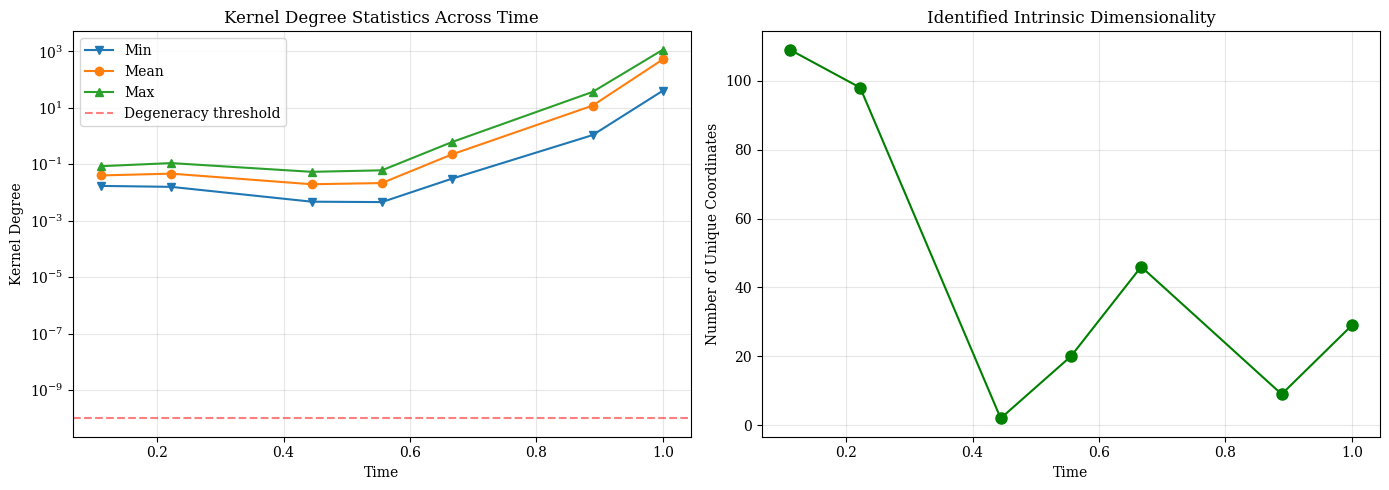

In [12]:
# Create diagnostic summary table
diag_summary = []
for idx, res in enumerate(analysis_results):
    diag = res['diagnostics']
    diag_summary.append({
        'Time': res['time'],
        'Epsilon': res['epsilon'],
        'Degree Min': diag.get('degree_min', np.nan),
        'Degree Mean': diag.get('degree_mean', np.nan),
        'Degree Max': diag.get('degree_max', np.nan),
        'Eigenvalues': diag.get('n_eigenvectors', 0),
        'Unique Coords': res['mask'].sum() if 'mask' in res else 0,
    })

diag_df = pd.DataFrame(diag_summary)
print("\n=== Diagnostic Summary Table ===")
print(diag_df.to_string(index=False))

# Visualize kernel degree statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.semilogy(diag_df['Time'], diag_df['Degree Min'], 'v-', label='Min', markersize=6)
ax.semilogy(diag_df['Time'], diag_df['Degree Mean'], 'o-', label='Mean', markersize=6)
ax.semilogy(diag_df['Time'], diag_df['Degree Max'], '^-', label='Max', markersize=6)
ax.axhline(y=1e-10, color='r', linestyle='--', alpha=0.5, label='Degeneracy threshold')
ax.set_xlabel('Time')
ax.set_ylabel('Kernel Degree')
ax.set_title('Kernel Degree Statistics Across Time')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(diag_df['Time'], diag_df['Unique Coords'], 'o-', color='green', markersize=8)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Unique Coordinates')
ax.set_title('Identified Intrinsic Dimensionality')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "diagnostic_summary.png", dpi=300, bbox_inches="tight")
plt.show()

## Cache Intermediate Results (Optional)

Save the computed results to cache for faster re-analysis.

In [13]:
# Save intermediate results to cache
cache_data = {
    'epsilon_results': epsilon_results,
    'diffusion_results': diffusion_results,
    'llr_results': llr_results,
    'analysis_results': analysis_results,
    'times_arr': times_arr,
}

with open(CACHE_DIR / "dimension_analysis_intermediate.pkl", "wb") as f:
    pickle.dump(cache_data, f)
print("Intermediate results cached successfully")

# To reload later, use:
# with open(CACHE_DIR / "dimension_analysis_intermediate.pkl", "rb") as f:
#     cache_data = pickle.load(f)
# epsilon_results = cache_data['epsilon_results']
# diffusion_results = cache_data['diffusion_results']
# llr_results = cache_data['llr_results']
# analysis_results = cache_data['analysis_results']
# times_arr = cache_data['times_arr']

Intermediate results cached successfully


## Save and Visualize Final Results

Now we'll save the results and create comprehensive visualizations.

In [17]:
def save_dimension_analysis_results(
    results,
    output_dir: Path,
    *,
    residual_threshold: float,
    metadata: Optional[Dict[str, Any]] = None,
) -> None:
    output_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    summary_rows = []
    for res in results:
        time_val = float(res["time"])
        eps_val = float(res["epsilon"])
        evals = np.asarray(res["eigenvalues"])
        residuals = np.asarray(res["residuals"])
        mask = res.get("mask")
        mask_arr = np.asarray(mask) if mask is not None else None
        num_unique = int(mask_arr.sum()) if mask_arr is not None else int((residuals >= residual_threshold).sum())

        summary_rows.append(
            {
                "time": time_val,
                "epsilon": eps_val,
                "num_eigenvectors": int(evals.shape[0]),
                "num_unique": num_unique,
            }
        )

        for idx, (eig, resid) in enumerate(zip(evals, residuals)):
            rows.append(
                {
                    "time": time_val,
                    "epsilon": eps_val,
                    "index": int(idx),
                    "eigenvalue": float(eig),
                    "abs_eigenvalue": float(abs(eig)),
                    "residual": float(resid),
                    "is_unique": bool(mask_arr[idx]) if mask_arr is not None else None,
                }
            )

    pd.DataFrame(rows).to_csv(output_dir / "dimension_analysis_long.csv", index=False)
    pd.DataFrame(summary_rows).to_csv(output_dir / "dimension_analysis_summary.csv", index=False)

    if metadata is None:
        metadata = {}
    meta_payload = dict(metadata)
    meta_payload["residual_threshold"] = float(residual_threshold)
    with open(output_dir / "dimension_analysis_metadata.json", "w", encoding="utf-8") as f:
        json.dump(meta_payload, f, indent=2, sort_keys=True)

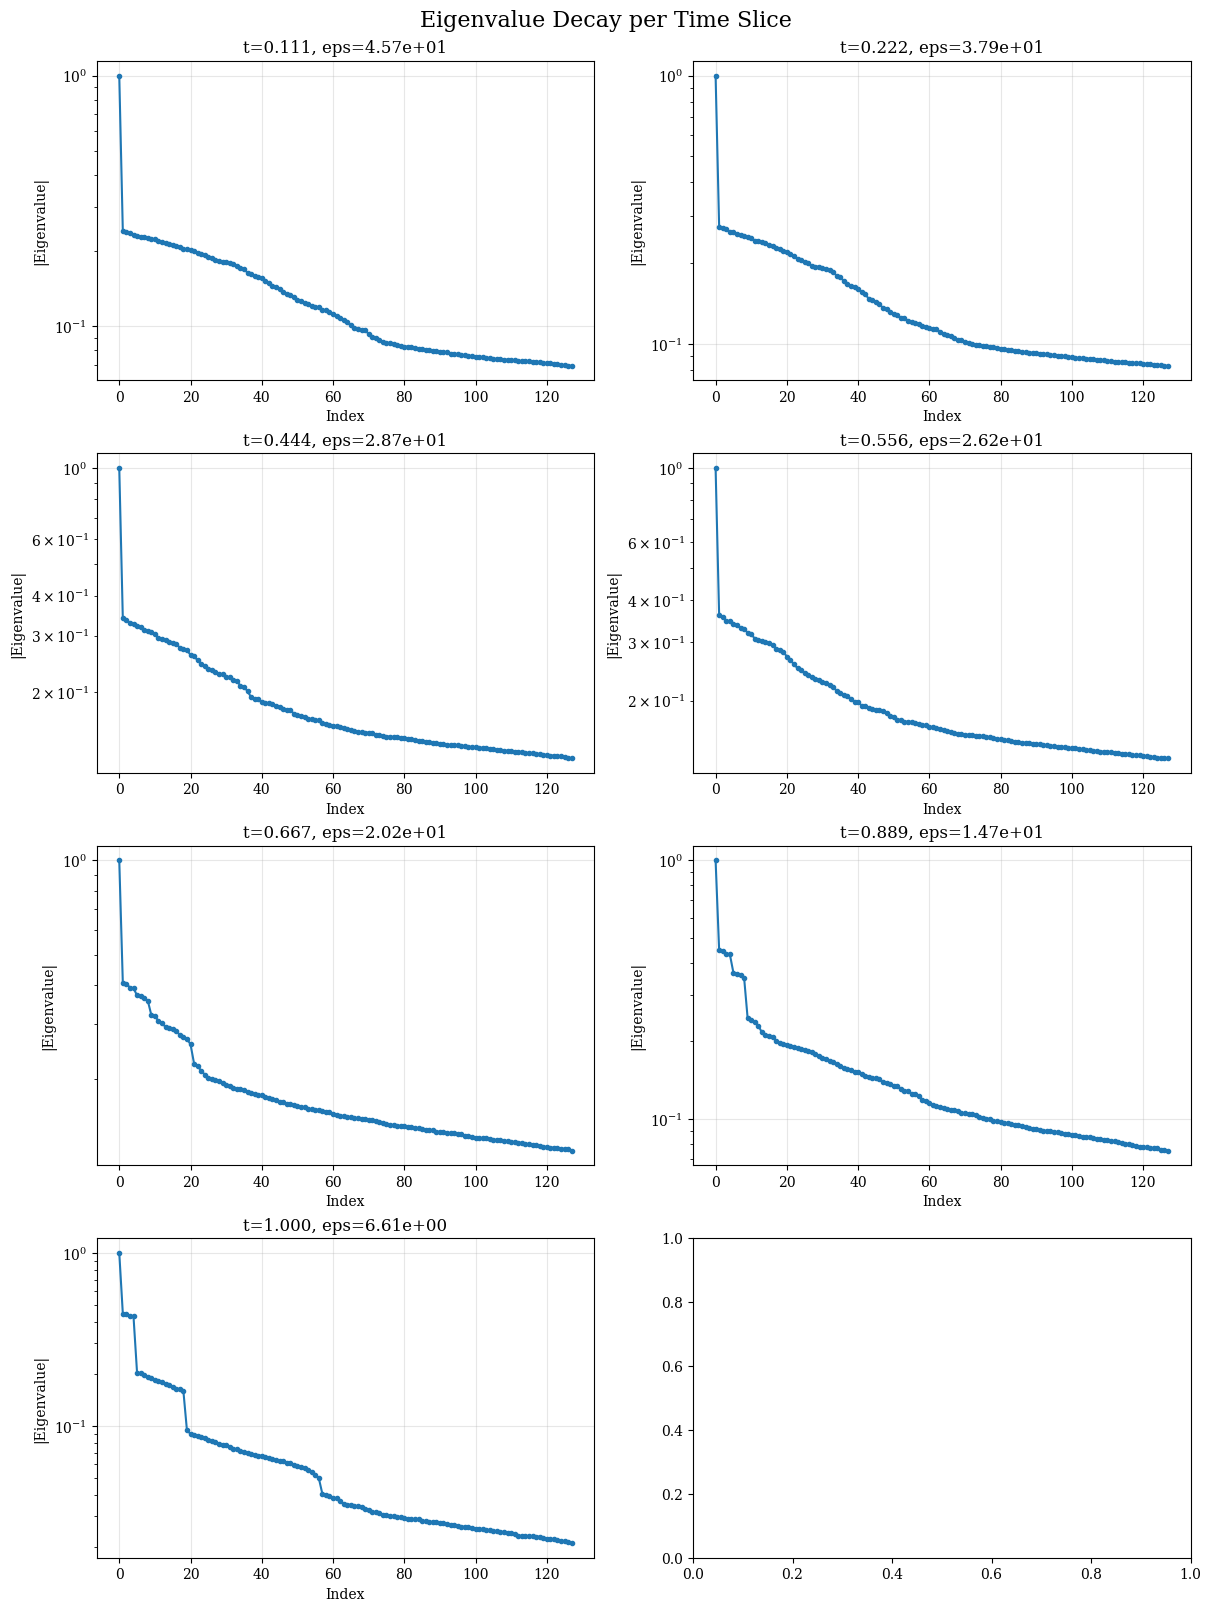

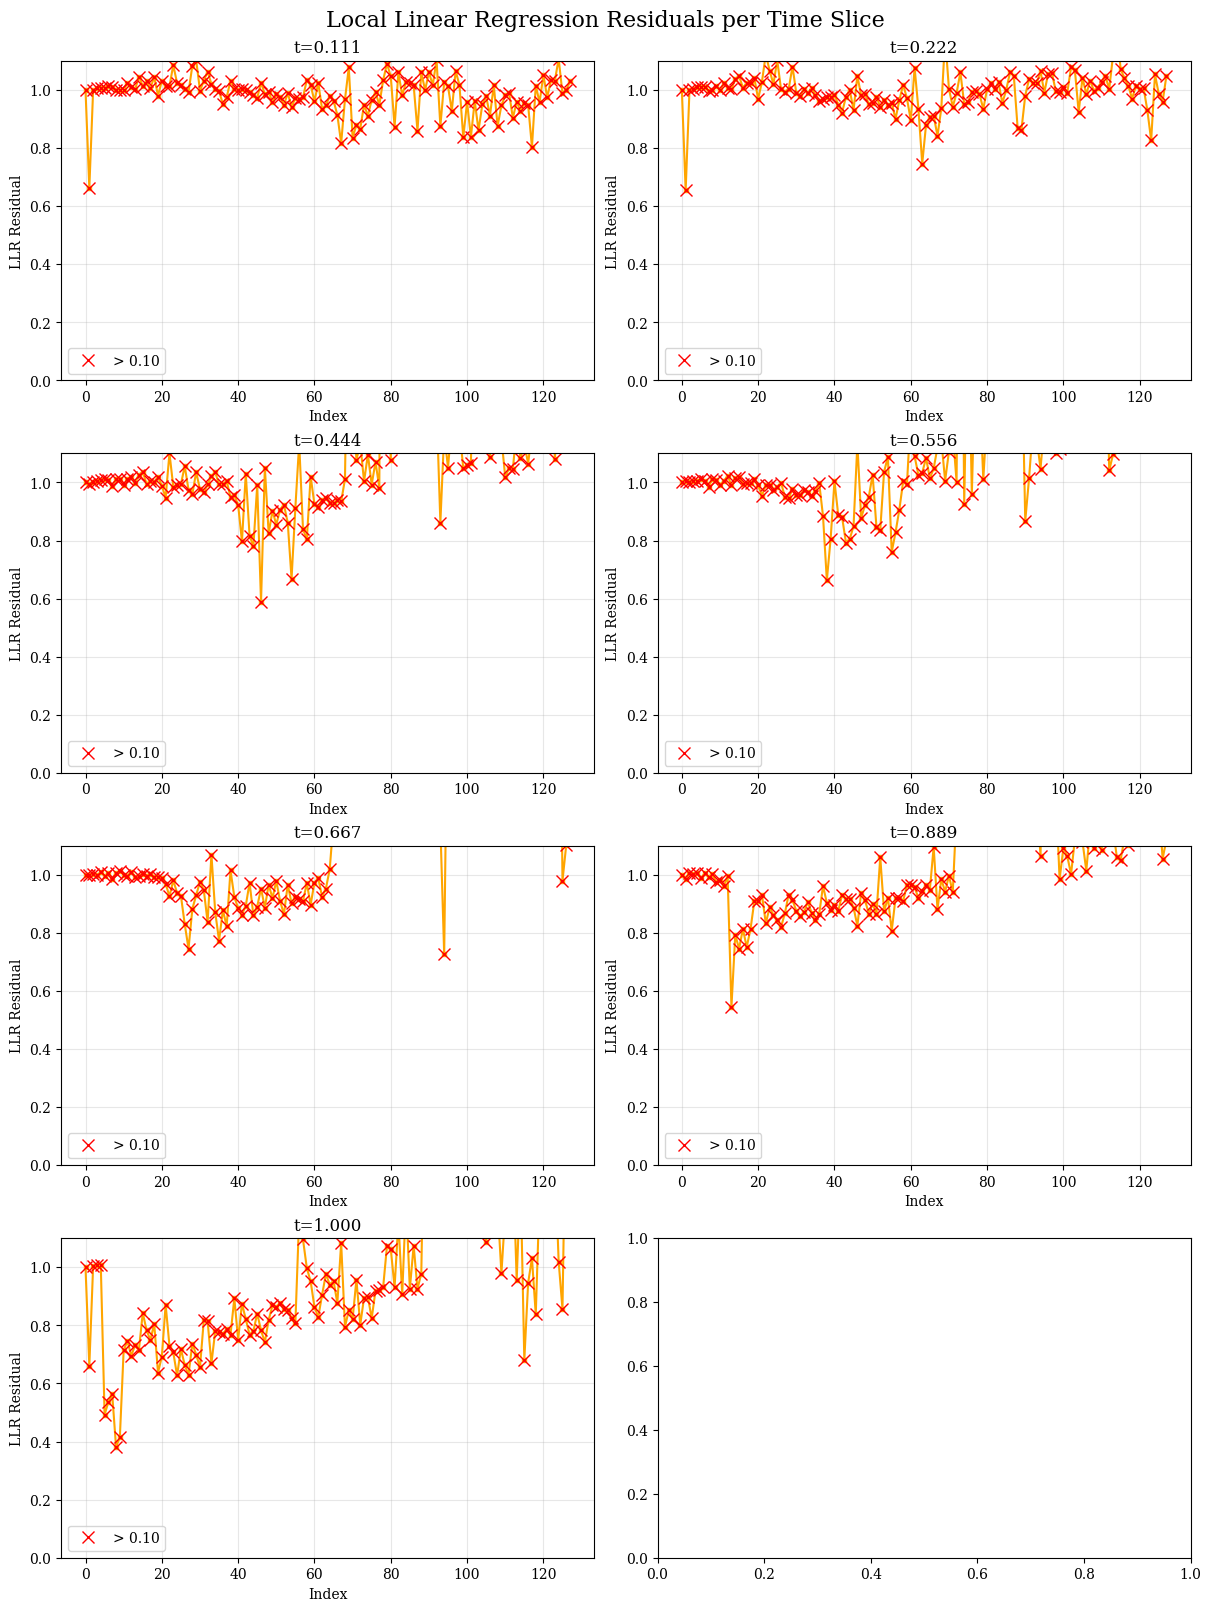

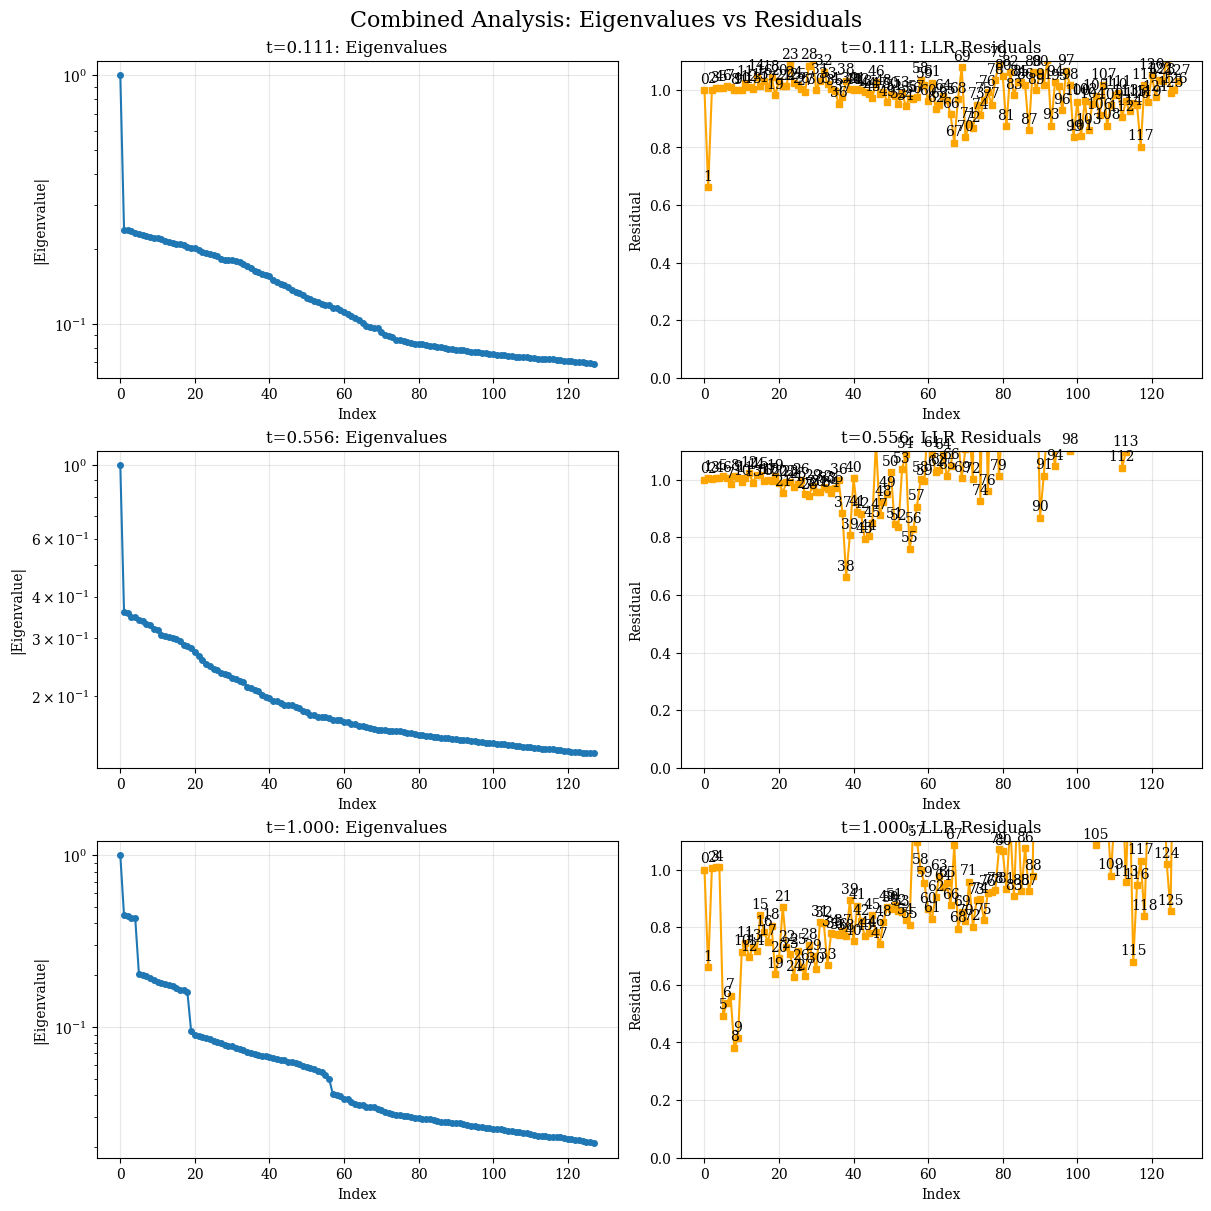

In [18]:
def plot_dimension_analysis(
    results,
    *,
    residual_threshold: float,
    output_dir: Optional[Path] = None,
    show: bool = True,
):
    n_times = len(results)
    n_cols = 2
    n_rows = int(np.ceil(n_times / n_cols))
    
    # Plot Eigenvalue Decay
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
    fig.suptitle("Eigenvalue Decay per Time Slice", fontsize=16)
    
    for idx, res in enumerate(results):
        ax = axes.flat[idx] if n_times > 1 else axes
        evals = res["eigenvalues"]
        # Plot log eigenvalues (excluding the first trivial one usually 1.0)
        # But let's plot all to see the gap.
        ax.plot(np.arange(len(evals)), np.abs(evals), 'o-', markersize=3)
        ax.set_yscale('log')
        ax.set_title(f"t={res['time']:.3f}, eps={res['epsilon']:.2e}")
        ax.set_xlabel("Index")
        ax.set_ylabel("|Eigenvalue|")
        ax.grid(True, alpha=0.3)
    if output_dir is not None:
        fig.savefig(output_dir / "eigenvalue_decay.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    # Plot LLR Residuals
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
    fig.suptitle("Local Linear Regression Residuals per Time Slice", fontsize=16)
    
    for idx, res in enumerate(results):
        ax = axes.flat[idx] if n_times > 1 else axes
        residuals = res["residuals"]
        # Residuals are for indices 1..k (index 0 is trivial constant)
        # residuals array size matches eigenvectors. 
        # Index 0 residual is usually 1.0 or 0.0 depending on implementation, but usually we care about 1+.
        
        ax.plot(np.arange(len(residuals)), residuals, 's-', color='orange', markersize=3)
        ax.set_ylim(0, 1.1)
        ax.set_title(f"t={res['time']:.3f}")
        ax.set_xlabel("Index")
        ax.set_ylabel("LLR Residual")
        ax.grid(True, alpha=0.3)
        
        # Highlight high scores
        high_score_indices = np.where(residuals > residual_threshold)[0]
        ax.plot(
            high_score_indices,
            residuals[high_score_indices],
            'rx',
            markersize=8,
            label=f"> {residual_threshold:.2f}",
        )
        ax.legend()
        
    if output_dir is not None:
        fig.savefig(output_dir / "llr_residuals.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    # Combined Plot for a few snapshots (e.g. first, middle, last)
    indices_to_plot = [0, n_times // 2, n_times - 1]
    fig, axes = plt.subplots(len(indices_to_plot), 2, figsize=(12, 4 * len(indices_to_plot)), constrained_layout=True)
    fig.suptitle("Combined Analysis: Eigenvalues vs Residuals", fontsize=16)
    
    for i, idx in enumerate(indices_to_plot):
        res = results[idx]
        evals = res["eigenvalues"]
        residuals = res["residuals"]
        
        # Eigenvalues
        ax_eig = axes[i, 0]
        ax_eig.plot(np.arange(len(evals)), np.abs(evals), 'o-', markersize=4)
        ax_eig.set_yscale('log')
        ax_eig.set_title(f"t={res['time']:.3f}: Eigenvalues")
        ax_eig.set_xlabel("Index")
        ax_eig.set_ylabel("|Eigenvalue|")
        ax_eig.grid(True, alpha=0.3)
        
        # Residuals
        ax_res = axes[i, 1]
        ax_res.plot(np.arange(len(residuals)), residuals, 's-', color='orange', markersize=4)
        ax_res.set_ylim(0, 1.1)
        ax_res.set_title(f"t={res['time']:.3f}: LLR Residuals")
        ax_res.set_xlabel("Index")
        ax_res.set_ylabel("Residual")
        ax_res.grid(True, alpha=0.3)
        
        # Annotate peaks
        peaks = np.where(residuals > residual_threshold)[0]
        for p in peaks:
            ax_res.annotate(f"{p}", (p, residuals[p]), xytext=(0, 5), textcoords='offset points', ha='center')

    if output_dir is not None:
        fig.savefig(output_dir / "combined_analysis.png", dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

save_dimension_analysis_results(
    analysis_results,
    OUTPUT_DIR,
    residual_threshold=LLR_RESIDUAL_THRESHOLD,
    metadata={
        "epsilon_selection_mode": epsilon_selection_mode,
        "max_eigenvectors": max_eigenvectors,
        "llr_residual_threshold": LLR_RESIDUAL_THRESHOLD,
    },
)
plot_dimension_analysis(
    analysis_results,
    residual_threshold=LLR_RESIDUAL_THRESHOLD,
    output_dir=OUTPUT_DIR,
    show=True,
)
